In [2]:
from pathlib import Path

import geopandas
import matplotlib.pyplot as plt
import pandas
import snail.damages

In [3]:
# set up variables for incoming and processed data paths
project_path = Path().resolve().parent # assume we're running from the project scripts directory, so get the parent
incoming_data_path = project_path / "incoming_data"
processed_data_path = project_path / "processed_data"

In [4]:
all_edges_with_damages = geopandas.read_file(project_path / "results" / "road_damages.gpkg")

In [5]:
all_edges_with_damages.query("jrc_flood_ead > 0").head(2)

,id,osm_id,name,ref,highway,lanes,paved,from_id,to_id,length_m,jrc_flood_rp500_damage_cost,jrc_flood_rp200_damage_cost,jrc_flood_rp100_damage_cost,jrc_flood_rp50_damage_cost,jrc_flood_rp20_damage_cost,jrc_flood_rp10_damage_cost,jrc_flood_ead,geometry
40,edge_40,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,node_44,node_46,2.375475,2704.477980,2638.130951,2585.751783,2533.372532,2386.354361,0.0,191.200520,"LINESTRING (15.27436 -4.32077, 15.27434 -4.32079)"
41,edge_41,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,node_46,node_43,169.906108,193438.103879,188692.624855,184946.198748,181199.766686,170684.274813,0.0,13675.639584,"LINESTRING (15.27434 -4.32079, 15.27314 -4.32174)"


<Axes: >

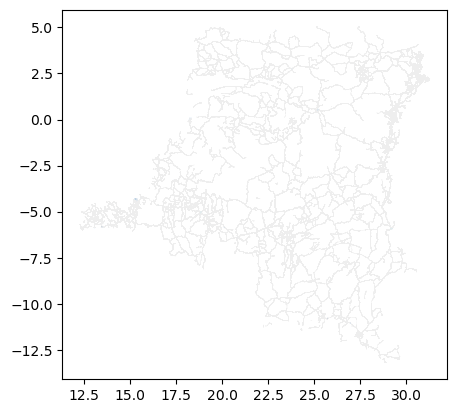

In [17]:
fig, ax = plt.subplots()
all_edges_with_damages.plot(ax=ax, color="#eeeeee", linewidth=0.2)
all_edges_with_damages.query("jrc_flood_ead > 0").plot(ax=ax, column="jrc_flood_ead", linewidth=1, cmap="Blues")

<Axes: ylabel='Frequency'>

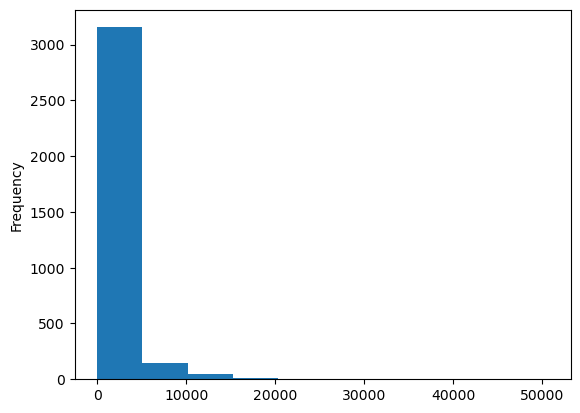

In [22]:
all_edges_with_damages.query("jrc_flood_ead > 0").jrc_flood_ead.plot.hist()

In [8]:
select_cols = ["paved", "length_m"] + [c for c in all_edges_with_damages.columns if "jrc_" in c]
all_edges_with_damages[select_cols].groupby(["paved"]).sum()

,length_m,jrc_flood_rp500_damage_cost,jrc_flood_rp200_damage_cost,jrc_flood_rp100_damage_cost,jrc_flood_rp50_damage_cost,jrc_flood_rp20_damage_cost,jrc_flood_rp10_damage_cost,jrc_flood_ead
paved,,,,,,,,
paved,1.107729e+07,5.617449e+07,5.335490e+07,5.094624e+07,4.842078e+07,4.445015e+07,1.279204e+07,3.860946e+06
unpaved,7.743770e+07,3.560092e+06,3.300207e+06,3.130511e+06,2.979820e+06,2.764714e+06,1.776452e+06,2.588077e+05


In [9]:
adaptation_options = pandas.read_csv(incoming_data_path / "hickford-2023-hvt-east-africa-adaptation" / "adaptation_options_and_costs.csv")
adaptation_options

,asset_name,asset_details,adaptation_option,option_unit_cost,asset_dimensions,initial_investment_cost_per_unit,periodic_maintenance_cost_per_unit,routine_maintenance_cost_per_unit,periodic_maintenance_intervals_years,routine_maintenance_intervals_years,a_scale_damage_fraction,b_translate_damage_fraction,c_ignore_up_to_probability,c_ignore_up_to_rp
0,road,all,Swales,USD/km,length,13430,2686,134,5,1,0.965,0.0,0.05,20
1,road,all,Spillways,USD/km,length,176193,35239,1762,5,1,0.900,0.0,0.10,10
2,road,all,Mobile flood embankments,USD/km,length,573068,114614,5731,5,1,1.000,-0.2,0.00,1
3,road,all,Flood Wall,USD/km,length,1230000,246000,12300,5,1,1.000,0.0,0.05,20
4,road,paved,Drainage (rehabilitation),USD/km,length,46843,9369,468,5,1,0.780,-0.1,0.02,50
5,road,unpaved,Upgrading to paved,USD/lane-km,area,247159,49432,2472,5,1,1.000,0.0,0.00,1


<Axes: xlabel='Hazard Intensity', ylabel='Damage Fraction'>

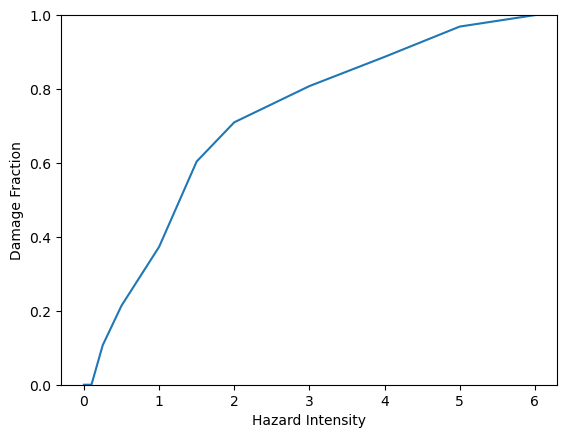

In [12]:
damage_curve = snail.damages.PiecewiseLinearDamageCurve.from_csv(
    incoming_data_path / "nirandjan-2024-vulnerabilty/road_damage.csv",
    intensity_col="depth_m",
    damage_col="paved"
)
damage_curve.plot()

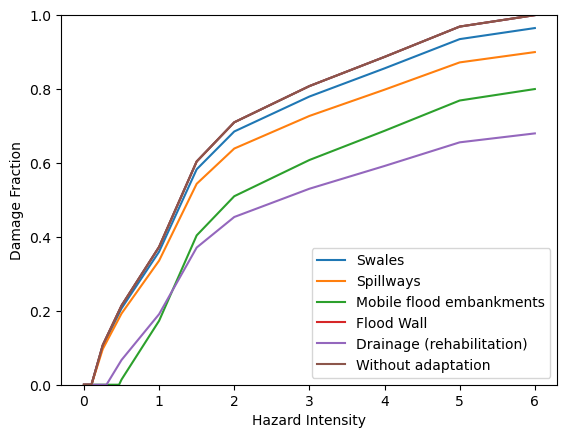

In [46]:
options_with_curves = {}
ax = damage_curve.plot()

for option in adaptation_options.itertuples():
    if option.asset_details == "unpaved":
        continue
    adapted_curve = (
        damage_curve
        .scale_y(option.a_scale_damage_fraction)
        .translate_y(option.b_translate_damage_fraction)
    )
    options_with_curves[option.adaptation_option] = {
        "name": option.adaptation_option,
        "initial_investment_cost_per_unit": option.initial_investment_cost_per_unit,
        "periodic_maintenance_cost_per_unit": option.periodic_maintenance_cost_per_unit,
        "routine_maintenance_cost_per_unit": option.routine_maintenance_cost_per_unit,
        "periodic_maintenance_intervals_years": option.periodic_maintenance_intervals_years,
        "routine_maintenance_intervals_years": option.routine_maintenance_intervals_years,
        "option_unit_cost": option.option_unit_cost,
        "curve": adapted_curve,
        "a_scale_damage_fraction": option.a_scale_damage_fraction,
        "b_translate_damage_fraction": option.b_translate_damage_fraction,
        "c_ignore_up_to_rp": option.c_ignore_up_to_rp,
    }
    # adapted_curve.plot(ax=ax)
    ax.plot(adapted_curve.intensity, adapted_curve.damage, label=option.adaptation_option)


ax.plot(damage_curve.intensity, damage_curve.damage, label="Without adaptation")
plt.legend()

In [21]:
split_damages = geopandas.read_parquet(project_path / "results" / "split_road_damages.gpq")

In [52]:
sample_assets = split_damages.query("jrc_flood_rp500_depth_m > 0 and paved == 'paved'").copy()
sample_assets

,osm_id,name,ref,highway,lanes,paved,id,from_id,to_id,length_m,...,jrc_flood_rp200_damage_fraction,jrc_flood_rp500_damage_fraction,cost_usd_per_km_per_lane,rehab_cost_usd,jrc_flood_rp50_damage_cost,jrc_flood_rp100_damage_cost,jrc_flood_rp10_damage_cost,jrc_flood_rp20_damage_cost,jrc_flood_rp200_damage_cost,jrc_flood_rp500_damage_cost
40,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,edge_40,node_44,node_46,2.375475,...,0.74038,0.759,500000,3563.212095,2533.372532,2585.751783,0.0,2386.354361,2638.130951,2704.477980
41,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,edge_41,node_46,node_43,169.906108,...,0.74038,0.759,500000,254859.161896,181199.766686,184946.198748,0.0,170684.274813,188692.624855,193438.103879
42,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,edge_42,node_43,node_47,51.822327,...,0.74038,0.759,500000,77733.490893,55266.957282,56409.640325,0.0,52059.672578,57552.321551,58999.719588
43,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,edge_43,node_47,node_48,33.437388,...,0.74038,0.759,500000,50156.082280,35659.971333,36397.266211,0.0,33590.530816,37134.559918,38068.466451
44,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,edge_44,node_48,node_49,25.274525,...,0.74038,0.759,500000,37911.788054,26954.523035,27511.826674,0.0,25390.282235,28069.129427,28775.047133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098542,1311532641,None,RN36,primary,2,paved,edge_1098542,node_1096282,node_1096283,89.025056,...,0.54394,0.657,500000,89025.056369,24430.255901,34851.527498,0.0,1905.135903,48424.289358,58489.462035
1098543,1311532641,None,RN36,primary,2,paved,edge_1098543,node_1096283,node_1096284,85.586852,...,0.54394,0.657,500000,85586.851832,23486.743815,33505.539247,0.0,1831.558338,46554.112374,56230.561653
1098544,1311532641,None,RN36,primary,2,paved,edge_1098544,node_1096284,node_1096285,57.078021,...,0.54394,0.657,500000,57078.021464,15663.350607,22344.902837,0.0,1221.469465,31047.019121,37500.260102
1098545,1311532641,None,RN36,primary,2,paved,edge_1098545,node_1096285,node_1096286,89.676358,...,0.54394,0.657,500000,89676.357564,24608.985975,35106.498879,0.0,1919.073747,48778.558131,58917.366920


In [54]:
for option_name, option in options_with_curves.items():
    adapted_curve = option["curve"]

    for colname in sample_assets.columns:
        if "depth_m" in colname:
            # damage fraction
            damage_fraction_col = colname.replace("depth_m", f"damage_fraction__{option_name}")
            rp = int(colname.replace("jrc_flood_rp", "").replace("_depth_m", ""))
            if rp > option["c_ignore_up_to_rp"]:
                damage_fraction = adapted_curve.damage_fraction(sample_assets[colname])
            else:
                damage_fraction = 0
            sample_assets[damage_fraction_col] = damage_fraction

            # damage cost
            damage_cost_col = colname.replace("depth_m", f"damage_cost__{option_name}")
            damage_cost = (
                sample_assets[colname]
                * sample_assets.cost_usd_per_km_per_lane
                * sample_assets.lanes
                * sample_assets.length_m
                / 1000
            )
            sample_assets[damage_cost_col] = damage_cost

    # adaptation cost
    sample_assets[f"adaptation_initial_investment_cost__{option_name}"] = (
        option["initial_investment_cost_per_unit"]
        * sample_assets.length_m
        / 1000
    )

sample_assets

,osm_id,name,ref,highway,lanes,paved,id,from_id,to_id,length_m,...,jrc_flood_rp200_damage_cost__Flood Wall,jrc_flood_rp500_damage_cost__Flood Wall,adaptation_initial_investment_cost__Flood Wall,jrc_flood_rp50_damage_cost__Drainage (rehabilitation),jrc_flood_rp100_damage_cost__Drainage (rehabilitation),jrc_flood_rp10_damage_cost__Drainage (rehabilitation),jrc_flood_rp20_damage_cost__Drainage (rehabilitation),jrc_flood_rp200_damage_cost__Drainage (rehabilitation),jrc_flood_rp500_damage_cost__Drainage (rehabilitation),adaptation_initial_investment_cost__Drainage (rehabilitation)
40,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,edge_40,node_44,node_46,2.375475,...,8231.019736,8908.030238,2921.833918,7162.056278,7696.538432,0.0,6449.413689,8231.019736,8908.030238,111.274363
41,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,edge_41,node_46,node_43,169.906108,...,588724.649396,637147.904739,208984.512754,512266.912980,550495.811569,0.0,461295.068448,588724.649396,637147.904739,7958.911814
42,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,edge_42,node_43,node_47,51.822327,...,179564.359515,194333.727233,63741.462532,156244.315954,167904.347001,0.0,140697.614068,179564.359515,194333.727233,2427.513276
43,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,edge_43,node_47,node_48,33.437388,...,115860.547198,125390.205701,41127.987470,100813.724905,108337.142031,0.0,90782.506058,115860.547198,125390.205701,1566.307575
44,4400953,Avenue Colonel Mondjiba,None,primary,3,paved,edge_44,node_48,node_49,25.274525,...,87576.228234,94779.470134,31087.666204,76202.693626,81889.465450,0.0,68620.334208,87576.228234,94779.470134,1183.934592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098542,1311532641,None,RN36,primary,2,paved,edge_1098542,node_1096282,node_1096283,89.025056,...,121964.327650,155793.848646,109500.819334,61427.288682,92586.055228,0.0,11573.256903,121964.327650,155793.848646,4170.200715
1098543,1311532641,None,RN36,primary,2,paved,edge_1098543,node_1096283,node_1096284,85.586852,...,117253.987418,149776.990705,105271.827753,59054.927560,89010.322640,0.0,11126.290330,117253.987418,149776.990705,4009.144900
1098544,1311532641,None,RN36,primary,2,paved,edge_1098544,node_1096284,node_1096285,57.078021,...,78196.889677,99886.537562,70205.966400,39383.834674,59361.140145,0.0,7420.142518,78196.889677,99886.537562,2673.705759
1098545,1311532641,None,RN36,primary,2,paved,edge_1098545,node_1096285,node_1096286,89.676358,...,122856.610291,156933.625738,110301.919804,61876.686506,93263.408446,0.0,11657.926056,122856.610291,156933.625738,4200.709617


In [ ]:
# TODO: EAD given adaptation, (baseline EAD - adapted EAD => avoided EAD, per option)
# TODO: NPV of costs and avoided risks, BCR
# see https://github.com/nismod/east-africa-transport/tree/main/src/eatra/adaptation for example